# Config

In [1]:
WB_CONFIG = {
    "epochs": 40,
    "batch_size": 16,
    "encoder_weights": None,
    "split_ratio": (0.8, 0.1, 0.1),
    "image_size": (512, 512),
    "loss": "dice_loss",
    "architecture": "resnet50",
    "learning_rate": 0.0003,
}
INTERNAL_CONFIG = WB_CONFIG.copy()
BUFFER_SIZE = 512

# Dataset initialization

## Helpers

In [5]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cv2 as cv
import wandb

def make_config(ds_size: int, split_ratio: tuple, batch_size: int) -> dict:
    assert sum(split_ratio) == 1
    train_size = int(ds_size * split_ratio[0])
    val_size = round(ds_size * split_ratio[1])
    test_size = round(ds_size * split_ratio[2])
    return {
        "train_size": train_size,
        "val_size": val_size,
        "test_size": test_size,
        "steps_per_epoch": train_size // batch_size,
        "val_steps": val_size // batch_size
    }

# Loads all paths to images and their corresponding masks and returns them as 2 tensors
def load_image_and_mask_paths(data_path: str):
    image_folder_path = data_path + "images/"
    mask_folder_path = data_path + "masks/"

    ids = [os.path.splitext(image)[0] for image in os.listdir(image_folder_path)]
    
    image_paths = [image_folder_path + id + ".jpg" for id in ids]
    mask_paths = [mask_folder_path + id + ".png" for id in ids]

    image_paths = tf.convert_to_tensor(image_paths, dtype=tf.string)
    mask_paths = tf.convert_to_tensor(mask_paths, dtype=tf.string)

    return image_paths, mask_paths

# Returns the function that loads a single image and its corresponding mask from the provided paths
def load_images_and_masks(image_size: tuple = (512, 512)):
    def load_images_func(image_path, mask_path):
        image = tf.io.read_file(image_path)
        image = tf.io.decode_jpeg(image, channels=3)
        image = tf.image.convert_image_dtype(image, tf.float32)
        image = tf.image.resize(image, image_size)

        mask = tf.io.read_file(mask_path)
        mask = tf.io.decode_png(mask, channels=1) // 255
        mask = tf.cast(mask, tf.float32)
        mask = tf.image.resize(mask, image_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

        return image, mask

    return load_images_func

# Splits the dataset into 2 parts based on the train_size and returns these 2 parts
def split(dataset, train_size):
    dataset = dataset.shuffle(buffer_size=BUFFER_SIZE)
    return dataset.take(train_size), dataset.skip(train_size)

def augment(seed=37):
    augment_image_model = tf.keras.Sequential([
        tf.keras.layers.RandomRotation(0.15, seed=seed),
        tf.keras.layers.RandomFlip(mode="horizontal_and_vertical", seed=seed),
    ])
    augment_mask_model = tf.keras.Sequential([
        tf.keras.layers.RandomRotation(0.15, seed=seed),
        tf.keras.layers.RandomFlip(mode="horizontal_and_vertical", seed=seed),
    ])
    rng = tf.random.Generator.from_seed(seed, alg='philox')

    def augment_func(image, mask):
        rng_seed = rng.make_seeds(1)[:, 0]
        image = tf.image.stateless_random_brightness(image, max_delta=0.1, seed=rng_seed)
        image = tf.image.stateless_random_contrast(image, 0.5, 1.5, seed=rng_seed)
        image = tf.image.stateless_random_hue(image, max_delta=0.1, seed=rng_seed)
        image = tf.image.stateless_random_saturation(image, 0.8, 1.2, seed=rng_seed)
        return augment_image_model((image)), augment_mask_model((mask))
    
    return augment_func

def draw_mask(image, mask) :
    mask_3_ch = np.repeat(np.round(mask), 3, axis=2)
    masked_image = np.where(mask_3_ch, np.array([0,255,0], dtype=np.uint8), image.copy())
    return cv.addWeighted(image, 0.5, masked_image, 0.5, 0)

def show(image, mask, prediction=None):
    image = (image * 255).astype('uint8')
    masked_image = draw_mask(image, mask)
    
    titles = ["Input Image", "True Mask", "Predicted Mask"]
    display_list = [image, masked_image] if prediction is None else [image, masked_image, draw_mask(image, prediction)]
    
    plt.figure(figsize=(15, 15))
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(titles[i])
        plt.imshow(display_list[i])
        plt.axis("off")
    
    plt.show()


class DisplayCallback(tf.keras.callbacks.Callback):
    def __init__(self, dataset):
        super().__init__()
        self._dataset = dataset
        
    def _make_wandb_mask(self, image, mask, prediction):
        return wandb.Image(image, masks={
            "prediction": {"mask_data": prediction.numpy()[:,:,0], "class_labels": {0: "tissue", 1:"nerve"}},
            "ground truth": {"mask_data": mask.numpy()[:,:,0], "class_labels": {0: "tissue", 1:"nerve"}}
        })
        
    def on_epoch_end(self, epoch, logs=None):
        imagelist = []
        for image, mask in self._dataset:
            imagelist.append(self._make_wandb_mask(image, mask, tf.math.round(model.predict(tf.expand_dims(image, axis=0))[0])))
        wandb.log({"segmentation_list": imagelist})

## Load dataset

In [10]:
import random

# Load nerve images and masks paths
DATA_PATH = "/kaggle/input/masters-thesis-extended/data/pancreas/nerves/"

image_paths, mask_paths = load_image_and_mask_paths(DATA_PATH)

# Load some tumor/non-tumor image paths with empty masks
TUMORS_DATA_PATH = "/kaggle/input/masters-thesis-extended/data/pancreas/tumors/images/"
EMPTY_NERVE_MASK_PATH = "/kaggle/working/empty_mask.png"
COUNT_TUMOR_IMAGES = 412
COUNT_NON_TUMOR_IMAGES = 413

empty_mask = np.zeros((512, 512, 1), dtype=np.uint8)
cv.imwrite(EMPTY_NERVE_MASK_PATH, empty_mask)

tumor_image_paths = [TUMORS_DATA_PATH + image for image in os.listdir(TUMORS_DATA_PATH) if "tumor" in image]
tumor_image_paths = random.sample(tumor_image_paths, COUNT_TUMOR_IMAGES)
non_tumor_image_paths = [TUMORS_DATA_PATH + image for image in os.listdir(TUMORS_DATA_PATH) if "empty" in image]
non_tumor_image_paths = random.sample(non_tumor_image_paths, COUNT_NON_TUMOR_IMAGES)
empty_mask_paths = [EMPTY_NERVE_MASK_PATH for _ in range(COUNT_TUMOR_IMAGES + COUNT_NON_TUMOR_IMAGES)]

tumor_image_paths = tf.convert_to_tensor(tumor_image_paths, dtype=tf.string)
non_tumor_image_paths = tf.convert_to_tensor(non_tumor_image_paths, dtype=tf.string)
empty_mask_paths = tf.convert_to_tensor(empty_mask_paths, dtype=tf.string)

image_paths = tf.concat([image_paths, tumor_image_paths, non_tumor_image_paths], axis=0)
mask_paths = tf.concat([mask_paths, empty_mask_paths], axis=0)

# Load dataset
dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
dataset = dataset.map(load_images_and_masks(INTERNAL_CONFIG["image_size"]))
ds_size = dataset.cardinality().numpy()

INTERNAL_CONFIG.update(make_config(ds_size, INTERNAL_CONFIG["split_ratio"], INTERNAL_CONFIG["batch_size"]))

train_ds, val_ds = split(dataset, INTERNAL_CONFIG["train_size"])
val_ds, test_ds = split(val_ds, INTERNAL_CONFIG["val_size"])

print(f"TRAIN: {train_ds.cardinality()}\nVAL: {val_ds.cardinality()}\nTEST: {test_ds.cardinality()}")

train_batches = (train_ds.shuffle(BUFFER_SIZE)
                         .map(augment())
                         .batch(INTERNAL_CONFIG["batch_size"])
                         .repeat()
                         .prefetch(buffer_size=tf.data.AUTOTUNE))

val_batches = val_ds.batch(INTERNAL_CONFIG["batch_size"])
test_batches = test_ds.batch(INTERNAL_CONFIG["batch_size"])

TRAIN: 1792
VAL: 224
TEST: 224


# Nerve segmentation model

## Prepare model

In [11]:
!pip install -q segmentation-models
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm

LOSS_CONFIG_TO_LOSS = {
    "dice_loss": sm.losses.dice_loss,
    "bce_dice_loss": sm.losses.bce_dice_loss,
    "binary_focal_dice_loss": sm.losses.binary_focal_dice_loss,
}

model = sm.Unet(INTERNAL_CONFIG["architecture"], encoder_weights=INTERNAL_CONFIG["encoder_weights"], input_shape=(*INTERNAL_CONFIG["image_size"], 3), classes=1, activation='sigmoid', encoder_freeze=INTERNAL_CONFIG["encoder_weights"] is not None)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INTERNAL_CONFIG["learning_rate"]),              
              loss=LOSS_CONFIG_TO_LOSS[INTERNAL_CONFIG["loss"]],
              metrics=[sm.metrics.iou_score, sm.metrics.f1_score, sm.metrics.precision, tf.keras.metrics.Recall()])

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


## Display architecture

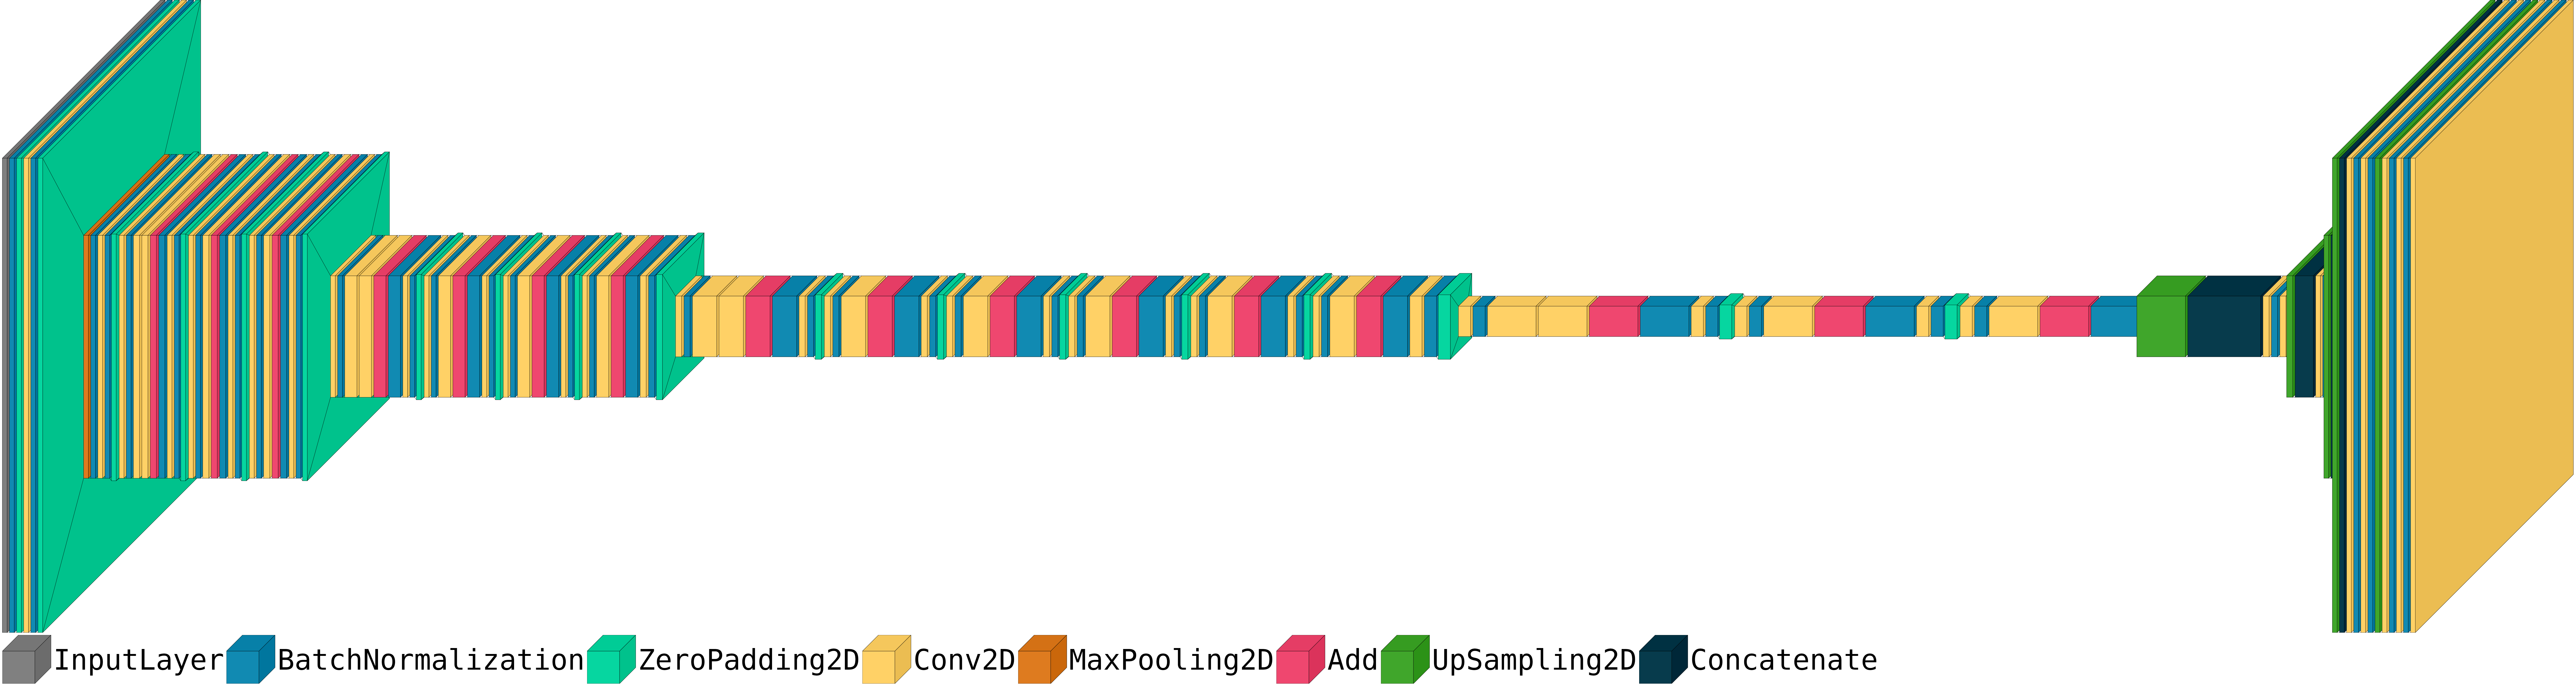

In [12]:
!pip install -q git+https://github.com/paulgavrikov/visualkeras
import visualkeras
from PIL import ImageFont

color_map = {
    tf.keras.layers.InputLayer: {"fill": "gray"},
    tf.keras.layers.BatchNormalization: {"fill": "#118ab2"},
    tf.keras.layers.ZeroPadding2D: {"fill": "#06d6a0"},
    tf.keras.layers.Conv2D: {"fill": "#ffd166"},
    tf.keras.layers.MaxPooling2D: {"fill": "#de7b1f"},
    tf.keras.layers.Add: {"fill": "#ef476f"},
    tf.keras.layers.UpSampling2D: {"fill": "#40a62b"},
    tf.keras.layers.Concatenate: {"fill": "#073b4c"},
}

font=ImageFont.truetype("DejaVuSansMono.ttf", 120)
visualkeras.layered_view(model, legend=True, font=font, color_map=color_map, type_ignore=[tf.keras.layers.Activation], scale_xy=8, max_xy=2000, min_xy=40)

# Training

In [13]:
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()

wandb.login(key=user_secrets.get_secret("wandb-api-key"))
wandb.init(project="nerve-segmentation", entity="xjackor", config=WB_CONFIG)

display_patches = dataset.take(8)

model.fit(train_batches,
          epochs=INTERNAL_CONFIG["epochs"],
          steps_per_epoch=INTERNAL_CONFIG["steps_per_epoch"],
          validation_steps=INTERNAL_CONFIG["val_steps"],
          validation_data=val_batches,
          callbacks=[DisplayCallback(display_patches), wandb.keras.WandbCallback()])

wandb.run.finish()

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: xjackor. Use `wandb login --relogin` to force relogin


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/40
112/112 [==============================] - ETA: 0s - loss: 0.6512 - iou_score: 0.2155 - f1-score: 0.3488 - precision: 0.2376 - recall: 0.7350

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240514_183846-cfb3kp0w/files/model-best)... Done. 1.5s


112/112 [==============================] - 228s 1s/step - loss: 0.6512 - iou_score: 0.2155 - f1-score: 0.3488 - precision: 0.2376 - recall: 0.7350 - val_loss: 0.9401 - val_iou_score: 0.0311 - val_f1-score: 0.0599 - val_precision: 0.0311 - val_recall: 0.9982
Epoch 2/40
112/112 [==============================] - 123s 1s/step - loss: 0.4671 - iou_score: 0.3724 - f1-score: 0.5329 - precision: 0.4651 - recall: 0.6642 - val_loss: 0.9417 - val_iou_score: 0.0305 - val_f1-score: 0.0583 - val_precision: 0.0333 - val_recall: 0.3030
Epoch 3/40
112/112 [==============================] - ETA: 0s - loss: 0.3609 - iou_score: 0.4795 - f1-score: 0.6391 - precision: 0.6320 - recall: 0.6760

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240514_183846-cfb3kp0w/files/model-best)... Done. 1.5s


112/112 [==============================] - 156s 1s/step - loss: 0.3609 - iou_score: 0.4795 - f1-score: 0.6391 - precision: 0.6320 - recall: 0.6760 - val_loss: 0.9136 - val_iou_score: 0.0461 - val_f1-score: 0.0864 - val_precision: 0.0470 - val_recall: 0.8016
Epoch 4/40
112/112 [==============================] - ETA: 0s - loss: 0.3529 - iou_score: 0.4908 - f1-score: 0.6471 - precision: 0.6578 - recall: 0.6694

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240514_183846-cfb3kp0w/files/model-best)... Done. 1.5s


112/112 [==============================] - 156s 1s/step - loss: 0.3529 - iou_score: 0.4908 - f1-score: 0.6471 - precision: 0.6578 - recall: 0.6694 - val_loss: 0.4691 - val_iou_score: 0.3852 - val_f1-score: 0.5309 - val_precision: 0.5150 - val_recall: 0.6238
Epoch 5/40
112/112 [==============================] - 128s 1s/step - loss: 0.3120 - iou_score: 0.5337 - f1-score: 0.6880 - precision: 0.6981 - recall: 0.7017 - val_loss: 0.6928 - val_iou_score: 0.1957 - val_f1-score: 0.3072 - val_precision: 0.2009 - val_recall: 0.9353
Epoch 6/40
112/112 [==============================] - ETA: 0s - loss: 0.3082 - iou_score: 0.5402 - f1-score: 0.6918 - precision: 0.7179 - recall: 0.6915

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240514_183846-cfb3kp0w/files/model-best)... Done. 1.5s


112/112 [==============================] - 155s 1s/step - loss: 0.3082 - iou_score: 0.5402 - f1-score: 0.6918 - precision: 0.7179 - recall: 0.6915 - val_loss: 0.4575 - val_iou_score: 0.4006 - val_f1-score: 0.5425 - val_precision: 0.4590 - val_recall: 0.7641
Epoch 7/40
112/112 [==============================] - 120s 1s/step - loss: 0.2949 - iou_score: 0.5542 - f1-score: 0.7051 - precision: 0.7296 - recall: 0.7078 - val_loss: 0.7872 - val_iou_score: 0.1211 - val_f1-score: 0.2128 - val_precision: 0.1237 - val_recall: 0.8370
Epoch 8/40
112/112 [==============================] - 125s 1s/step - loss: 0.2925 - iou_score: 0.5553 - f1-score: 0.7075 - precision: 0.7438 - recall: 0.6964 - val_loss: 0.5680 - val_iou_score: 0.2980 - val_f1-score: 0.4320 - val_precision: 0.3193 - val_recall: 0.8073
Epoch 9/40
112/112 [==============================] - 121s 1s/step - loss: 0.2934 - iou_score: 0.5546 - f1-score: 0.7066 - precision: 0.7335 - recall: 0.7057 - val_loss: 0.7681 - val_iou_score: 0.1418 - v

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240514_183846-cfb3kp0w/files/model-best)... Done. 1.5s


112/112 [==============================] - 157s 1s/step - loss: 0.2665 - iou_score: 0.5882 - f1-score: 0.7335 - precision: 0.7618 - recall: 0.7227 - val_loss: 0.3209 - val_iou_score: 0.5331 - val_f1-score: 0.6791 - val_precision: 0.6278 - val_recall: 0.7528
Epoch 13/40
112/112 [==============================] - 120s 1s/step - loss: 0.2702 - iou_score: 0.5860 - f1-score: 0.7298 - precision: 0.7524 - recall: 0.7277 - val_loss: 0.6447 - val_iou_score: 0.2526 - val_f1-score: 0.3553 - val_precision: 0.4991 - val_recall: 0.3737
Epoch 14/40
112/112 [==============================] - 124s 1s/step - loss: 0.2844 - iou_score: 0.5674 - f1-score: 0.7156 - precision: 0.7571 - recall: 0.6998 - val_loss: 0.6544 - val_iou_score: 0.2258 - val_f1-score: 0.3456 - val_precision: 0.2314 - val_recall: 0.8942
Epoch 15/40
112/112 [==============================] - 126s 1s/step - loss: 0.2566 - iou_score: 0.6022 - f1-score: 0.7434 - precision: 0.7667 - recall: 0.7452 - val_loss: 0.6454 - val_iou_score: 0.2470 

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240514_183846-cfb3kp0w/files/model-best)... Done. 1.5s


112/112 [==============================] - 153s 1s/step - loss: 0.2428 - iou_score: 0.6153 - f1-score: 0.7572 - precision: 0.7823 - recall: 0.7443 - val_loss: 0.2776 - val_iou_score: 0.5797 - val_f1-score: 0.7224 - val_precision: 0.8435 - val_recall: 0.6697
Epoch 19/40
112/112 [==============================] - 121s 1s/step - loss: 0.2273 - iou_score: 0.6372 - f1-score: 0.7727 - precision: 0.7923 - recall: 0.7668 - val_loss: 0.6683 - val_iou_score: 0.2325 - val_f1-score: 0.3317 - val_precision: 0.7455 - val_recall: 0.3136
Epoch 20/40
112/112 [==============================] - 125s 1s/step - loss: 0.2348 - iou_score: 0.6261 - f1-score: 0.7652 - precision: 0.7955 - recall: 0.7415 - val_loss: 0.3408 - val_iou_score: 0.5210 - val_f1-score: 0.6592 - val_precision: 0.6261 - val_recall: 0.7894
Epoch 21/40
112/112 [==============================] - 123s 1s/step - loss: 0.2471 - iou_score: 0.6121 - f1-score: 0.7529 - precision: 0.7809 - recall: 0.7433 - val_loss: 0.4378 - val_iou_score: 0.4223 

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240514_183846-cfb3kp0w/files/model-best)... Done. 1.6s


112/112 [==============================] - 159s 1s/step - loss: 0.2032 - iou_score: 0.6687 - f1-score: 0.7968 - precision: 0.8228 - recall: 0.7790 - val_loss: 0.1964 - val_iou_score: 0.6827 - val_f1-score: 0.8036 - val_precision: 0.8544 - val_recall: 0.7825
Epoch 26/40
112/112 [==============================] - 119s 1s/step - loss: 0.2044 - iou_score: 0.6663 - f1-score: 0.7956 - precision: 0.8224 - recall: 0.7770 - val_loss: 0.2646 - val_iou_score: 0.5931 - val_f1-score: 0.7354 - val_precision: 0.8328 - val_recall: 0.6462
Epoch 27/40
112/112 [==============================] - 126s 1s/step - loss: 0.1912 - iou_score: 0.6838 - f1-score: 0.8088 - precision: 0.8336 - recall: 0.7906 - val_loss: 0.5060 - val_iou_score: 0.3398 - val_f1-score: 0.4940 - val_precision: 0.3535 - val_recall: 0.9127
Epoch 28/40
112/112 [==============================] - 122s 1s/step - loss: 0.1963 - iou_score: 0.6788 - f1-score: 0.8037 - precision: 0.8309 - recall: 0.7836 - val_loss: 0.6371 - val_iou_score: 0.2476 

# Evaluate

In [14]:
model.evaluate(test_batches)

14/14 [==============================] - 28s 213ms/step - loss: 0.1434 - iou_score: 0.7563 - f1-score: 0.8566 - precision: 0.9471 - recall: 0.7932


[0.1434468924999237,
 0.7563109397888184,
 0.8565531373023987,
 0.9470729827880859,
 0.7931740880012512]

1/1 [==============================] - 0s 28ms/step


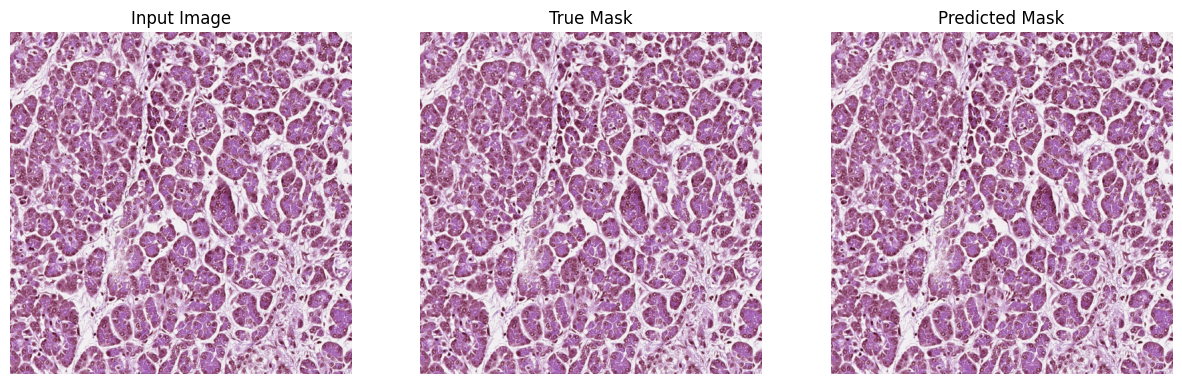

1/1 [==============================] - 0s 30ms/step


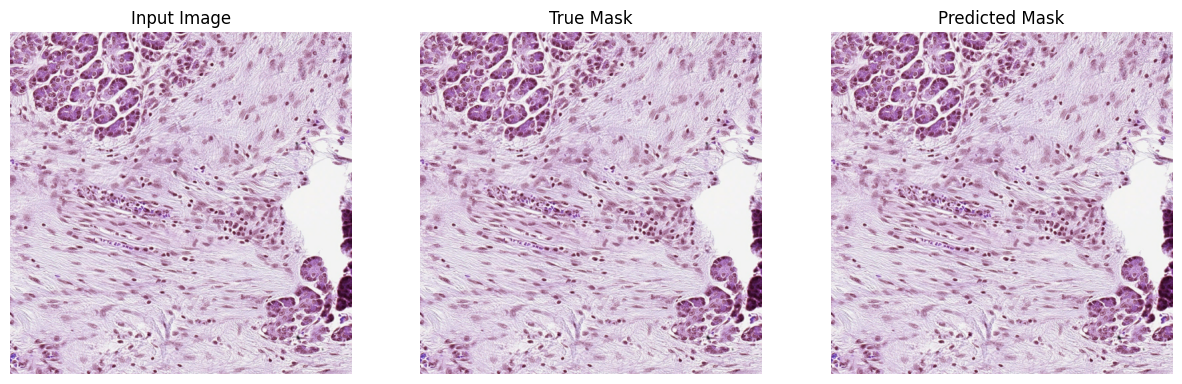

1/1 [==============================] - 0s 28ms/step


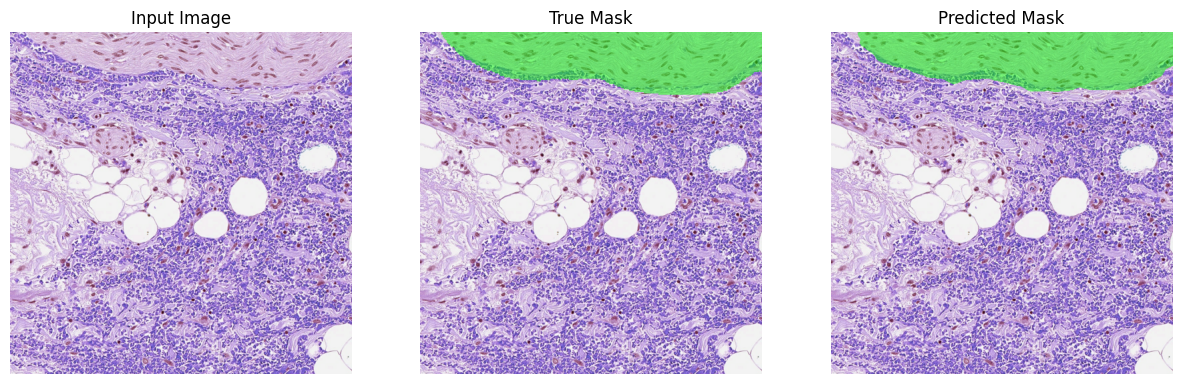

1/1 [==============================] - 0s 32ms/step


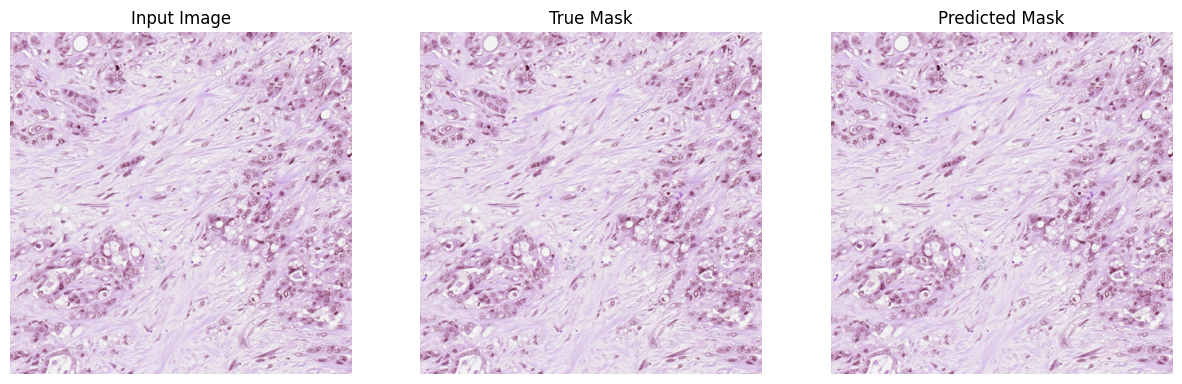

1/1 [==============================] - 0s 28ms/step


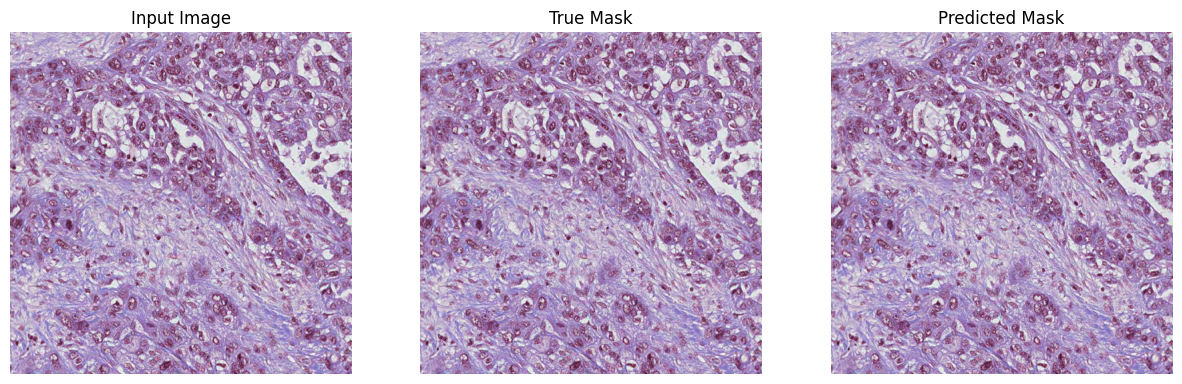

1/1 [==============================] - 0s 28ms/step


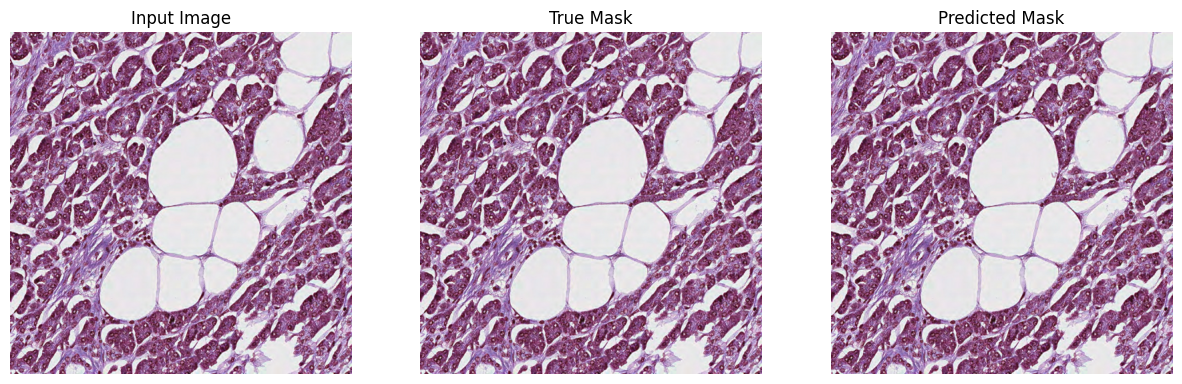

1/1 [==============================] - 0s 26ms/step


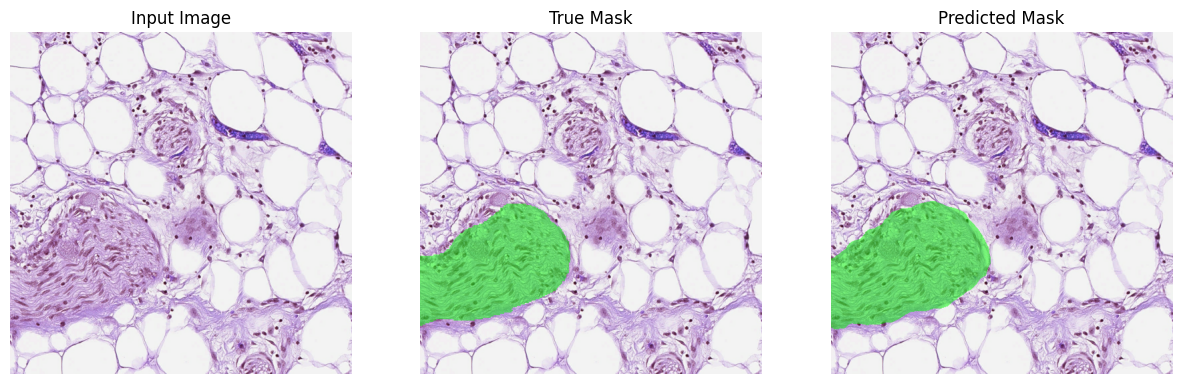

1/1 [==============================] - 0s 26ms/step


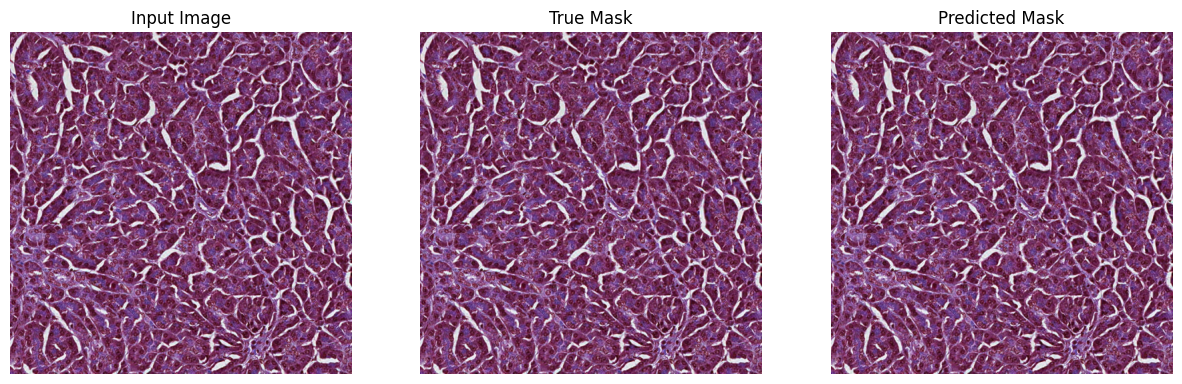

1/1 [==============================] - 0s 26ms/step


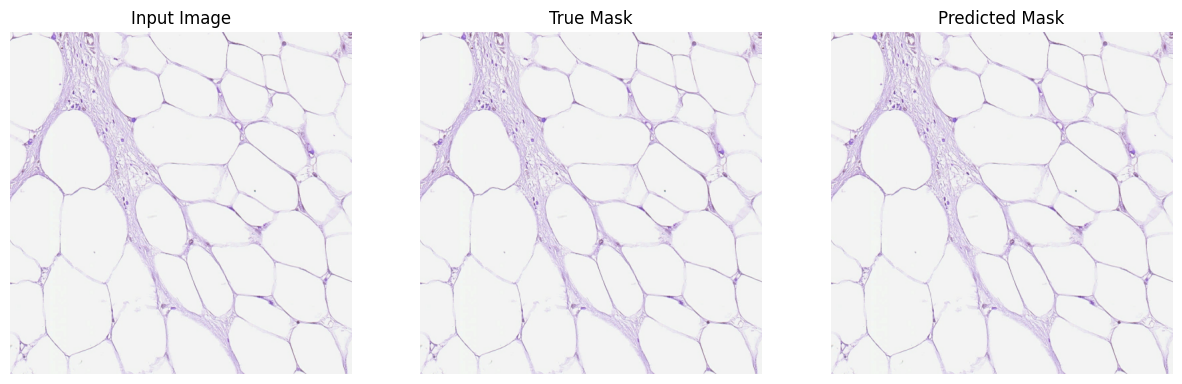

1/1 [==============================] - 0s 25ms/step


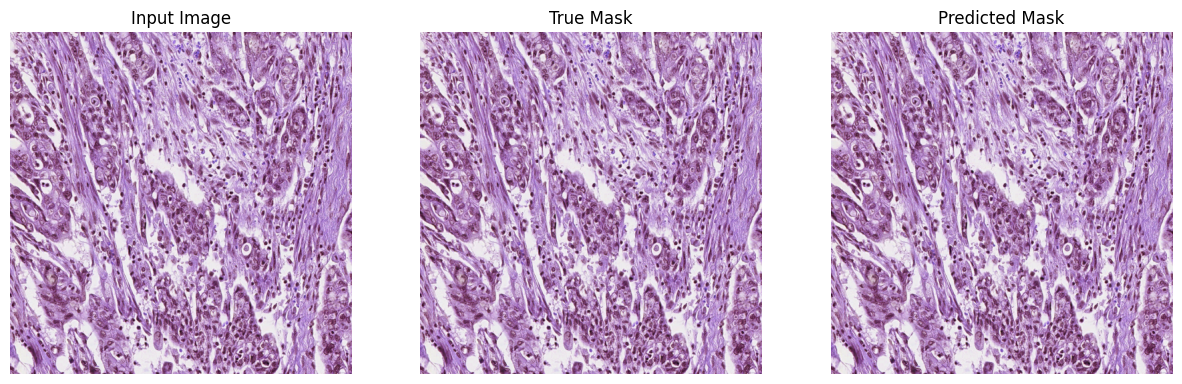

1/1 [==============================] - 0s 26ms/step


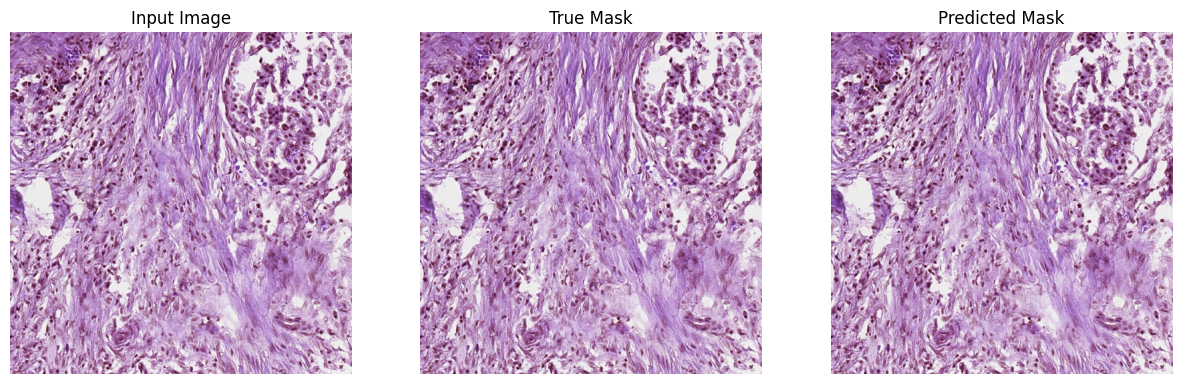

1/1 [==============================] - 0s 26ms/step


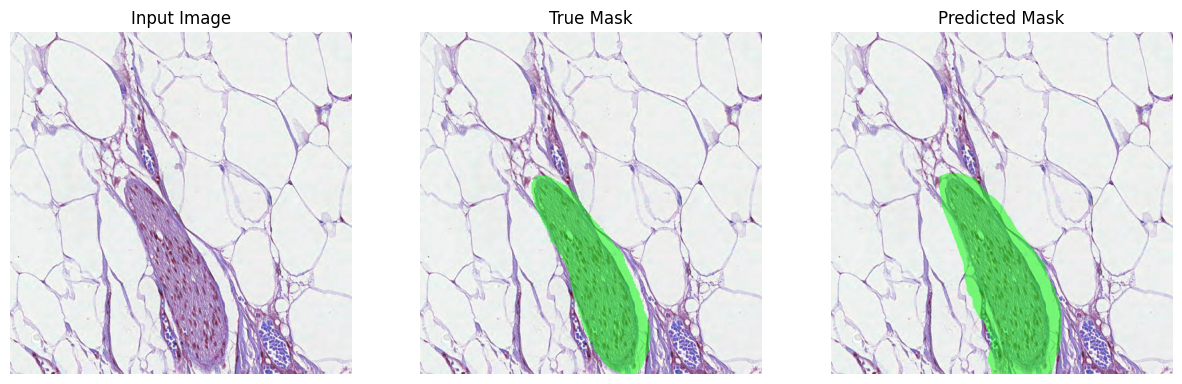

1/1 [==============================] - 0s 26ms/step


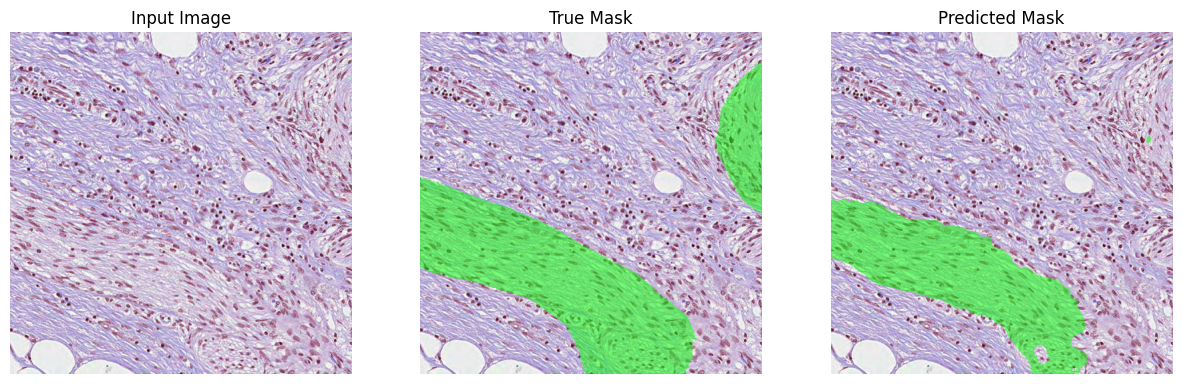

1/1 [==============================] - 0s 26ms/step


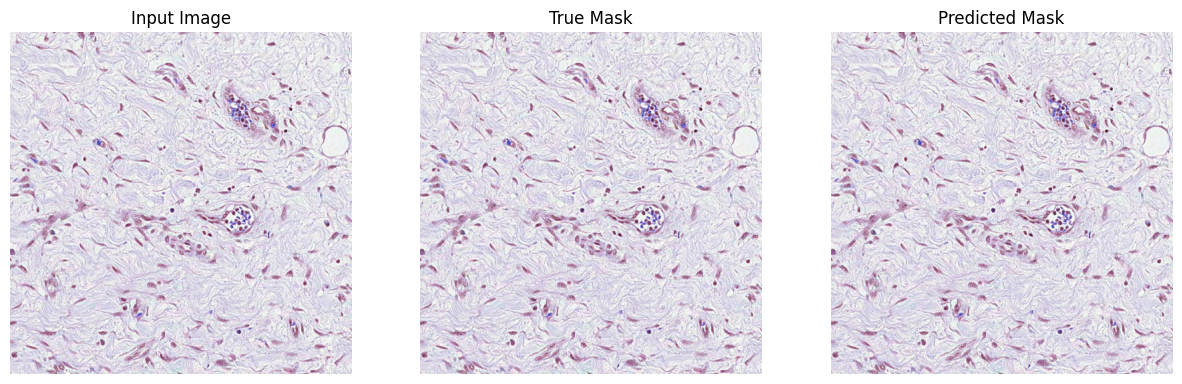

1/1 [==============================] - 0s 25ms/step


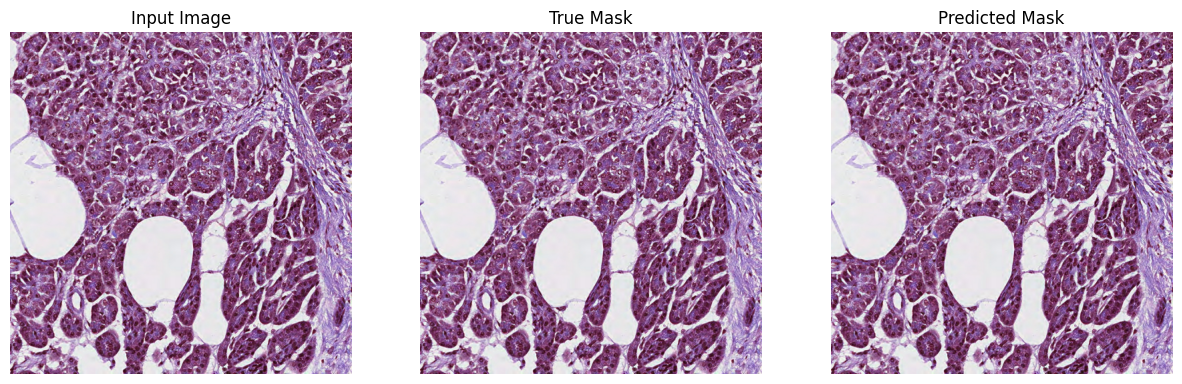

1/1 [==============================] - 0s 26ms/step


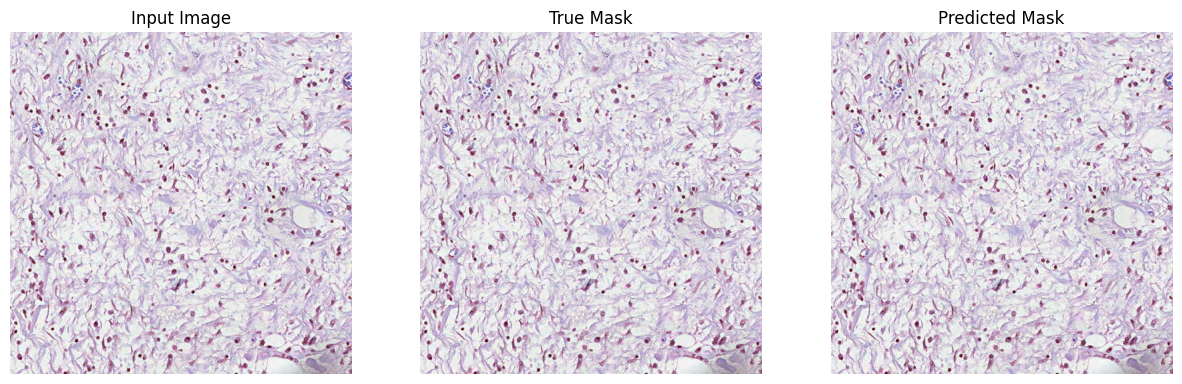

In [16]:
for images, masks in test_batches.take(10):
    for image, mask in zip(images, masks):
        show(image.numpy(), mask.numpy(), model.predict(tf.expand_dims(image, axis=0))[0])